In [1]:
!python -V
fillna = True

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
#wget data from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
df = pd.read_parquet('~/data/fhv_tripdata_2021-01.parquet')
df.head(),df.shape

(  dispatching_base_num     pickup_datetime    dropOff_datetime  PUlocationID  \
 0               B00009 2021-01-01 00:27:00 2021-01-01 00:44:00           NaN   
 1               B00009 2021-01-01 00:50:00 2021-01-01 01:07:00           NaN   
 2               B00013 2021-01-01 00:01:00 2021-01-01 01:51:00           NaN   
 3               B00037 2021-01-01 00:13:09 2021-01-01 00:21:26           NaN   
 4               B00037 2021-01-01 00:38:31 2021-01-01 00:53:44           NaN   
 
    DOlocationID  SR_Flag Affiliated_base_number  
 0           NaN      NaN                 B00009  
 1           NaN      NaN                 B00009  
 2           NaN      NaN                 B00013  
 3          72.0      NaN                 B00037  
 4          61.0      NaN                 B00037  ,
 (1154112, 7))

In [7]:
df = pd.read_parquet('~/data/fhv_tripdata_2021-01.parquet')

df['lpep_pickup_datetime'] = df.pickup_datetime
df['lpep_dropoff_datetime'] = df.dropOff_datetime
df['PULocationID'] = df.PUlocationID
df['DOLocationID'] = df.DOlocationID

if fillna:
    df['PULocationID'] = df.PUlocationID.fillna(-1)
    df['DOLocationID'] = df.DOlocationID.fillna(-1)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
print('df.duration.mean()=',df.duration.mean())
num_rec=df.shape[0]
print('df.shape before drop',num_rec)
df = df[(df.duration >= 1) & (df.duration <= 60)]
print('df.shape after drop',df.shape[0])
print('num rec dropped=',num_rec-df.shape[0])
categorical = ['PULocationID', 'DOLocationID']
#numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

print('The fractions of missing values for the pickup location ID:',
      df[df["PULocationID"]=='-1.0'].count()["PULocationID"] / df.shape[0])

df.duration.mean()= 19.1672240937939
df.shape before drop 1154112
df.shape after drop 1109826
num rec dropped= 44286
The fractions of missing values for the pickup location ID: 0.8352732770722617


In [8]:
#train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
print('The number of columns=',X_train.shape[1])
mean_squared_error(y_train, y_pred, squared=False)

The number of columns= 525


10.5285191072072

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


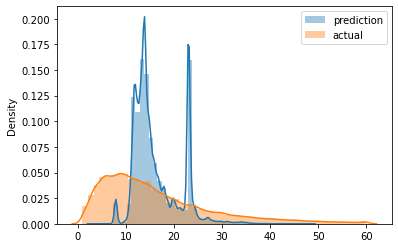

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        
        df['lpep_pickup_datetime'] = df.pickup_datetime
        df['lpep_dropoff_datetime'] = df.dropOff_datetime
        df['PULocationID'] = df.PUlocationID
        df['DOLocationID'] = df.DOlocationID
        
        if fillna:
            df['PULocationID'] = df.PUlocationID.fillna(-1)
            df['DOLocationID'] = df.DOlocationID.fillna(-1)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
        
        df['lpep_pickup_datetime'] = df.pickup_datetime
        df['lpep_dropoff_datetime'] = df.dropOff_datetime
        df['PULocationID'] = df.PUlocationID
        df['DOLocationID'] = df.DOlocationID
        
        if fillna:
            df['PULocationID'] = df.PUlocationID.fillna(-1)
            df['DOLocationID'] = df.DOlocationID.fillna(-1)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('~/data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('~/data/fhv_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(1109826, 990113)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
#numerical = ['trip_distance']

dv = DictVectorizer()

#train_dicts = df_train[categorical + numerical].to_dict(orient='records')
train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

#val_dicts = df_val[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.596293703772497

In [39]:
with open(os.path.expanduser('~/models')+'/fhv_lin_reg.bin', 'wb') as f_out:
          pickle.dump((dv, lr), f_out)


In [ ]:
if False:
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mean_squared_error(y_val, y_pred, squared=False)